### Analyze the Spread of Novel CoronaVirus 
#### Data Source: [Johns Hopkins University](https://docs.google.com/spreadsheets/d/1wQVypefm946ch4XDp37uZ-wartW4V7ILdg-qYiDXUHM/htmlview?sle=true)

#### How to [access](https://towardsdatascience.com/accessing-google-spreadsheet-data-using-python-90a5bc214fd2) 

In [1]:
import pandas as pd
import numpy as np
from datetime import timedelta
import matplotlib.pyplot as plt
import gspread
from oauth2client.service_account import ServiceAccountCredentials

from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.stattools import acf
from scipy import stats

In [2]:
scope = ['https://spreadsheets.google.com/feeds','https://www.googleapis.com/auth/drive']
creds = ServiceAccountCredentials.from_json_keyfile_name('client_secret.json', scope)
client = gspread.authorize(creds)

#### Load all sheets in the underlying file

In [3]:
##sheet = client.open('Learning Log').sheet1
url = 'https://docs.google.com/spreadsheets/d/1wQVypefm946ch4XDp37uZ-wartW4V7ILdg-qYiDXUHM/htmlview?sle=true'
sheet = client.open_by_url(url)
worksheet_list = sheet.worksheets()

len(worksheet_list)

raw_df = pd.DataFrame()
for worksheet in worksheet_list:
    sub_data = worksheet.get_all_records()
    sub_table = pd.DataFrame(sub_data)
    sub_table['sheet_name'] = worksheet._properties['title']
    raw_df = pd.concat([raw_df, sub_table])

raw_df.head()

/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  del sys.path[0]


,,Confirmed,Country,Country/Region,Date last updated,Deaths,Demised,Last Update,Province/State,"Quick note: Starting from this tab, our map is updating (almost) in real time (China data - at least once per hour; non China data - several times per day). This table is planning to be updated twice a day. The discrepancy between the map and this sheet is expected. Sorry for any confusion and inconvenience.",Recovered,Suspected,sheet_name
0,NaN,22112,NaN,Mainland China,NaN,618,NaN,2/7/20 14:03,Hubei,NaN,867,NaN,Feb07_0813PM
1,NaN,1034,NaN,Mainland China,NaN,1,NaN,2/7/20 10:13,Guangdong,NaN,88,NaN,Feb07_0813PM
2,NaN,1006,NaN,Mainland China,NaN,0,NaN,2/7/20 11:33,Zhejiang,NaN,123,NaN,Feb07_0813PM
3,NaN,914,NaN,Mainland China,NaN,3,NaN,2/7/20 14:03,Henan,NaN,86,NaN,Feb07_0813PM
4,NaN,772,NaN,Mainland China,NaN,0,NaN,2/7/20 11:33,Hunan,NaN,112,NaN,Feb07_0813PM


In [4]:
# Merge duplicate columns with different names

main_df = raw_df

main_df.loc[main_df.Deaths.isna(),'Deaths'] =  main_df.loc[main_df.Deaths.isna(),'Demised']

main_df.loc[main_df['Country/Region'].isna(),'Country/Region'] =  main_df.loc[main_df['Country/Region'].isna(),'Country']
#main_df.loc[main_df['Country/Region'].isna(),'Country/Region'] =  main_df.loc[main_df['Country/Region'].isna(),'Country_Region']

#main_df.loc[main_df['Province/State'].isna(),'Province/State'] =  main_df.loc[main_df['Province/State'].isna(),'Province_State']

main_df.loc[main_df['Last Update'].isna(),'Last Update'] = main_df.loc[main_df['Last Update'].isna(),'Date last updated']
#main_df.loc[main_df['Last Update (UTC)'].isna(),'Last Update (UTC)'] = main_df.loc[main_df['Last Update (UTC)'].isna(),'Last_Update']
#main_df.loc[main_df['Last Update'].isna(),'Last Update'] = main_df.loc[main_df['Last Update'].isna(),'Last Update (UTC)']

main_df.loc[main_df['Province/State'].isna(), 'Province/State'] = main_df.loc[main_df['Province/State'].isna(), 'Country/Region']
main_df.loc[main_df['Province/State']=='', 'Province/State'] = main_df.loc[main_df['Province/State']=='', 'Country/Region']

main_df = main_df.loc[:, ~main_df.columns.isin(['Demised' , 'Country' , 'Country_Region','Province_State',
                                                'Date last updated', 'Last Update (UTC)', 'Last_Update','',
                                               'Quick note: Starting from this tab, our map is updating (almost) in real time (China data - at least once per hour; non China data - several times per day). This table is planning to be updated twice a day. The discrepancy between the map and this sheet is expected. Sorry for any confusion and inconvenience.'])]
main_df.sample(5)

,Confirmed,Country/Region,Deaths,Last Update,Province/State,Recovered,Suspected,sheet_name
11,99,Mainland China,,1/29/2020 14:30,Jiangsu,1,NaN,Jan29_230pm
50,2,Philippines,1,2/2/20 3:33,Philippines,0,NaN,Feb06_0805PM
33,15,South Korea,0,2/2/2020 2:23,South Korea,0,NaN,Feb02_9PM
8,72,Mainland China,,1/27/2020 19:00,Jiangxi,2,NaN,Jan27_7pm
54,2,US,0,2/3/2020 0:43,"Santa Clara, CA",0,NaN,Feb03_1230pm


In [5]:
# merge duplicate country names
main_df['Country/Region'] = main_df['Country/Region'].str.replace(r'^China','Mainland China')
main_df['Country/Region'] = main_df['Country/Region'].str.replace(r'United States','US')

main_df['Last Update'] = pd.to_datetime(main_df['Last Update'])
main_df['Last Update'] = main_df['Last Update'] - timedelta(hours=2) # to deal with cases reported too early on next day


main_df['month'] = main_df.sheet_name.str.split('_').apply(lambda x: x[0][:3])
main_df['day'] = main_df.sheet_name.str.split('_').apply(lambda x: x[0][3:])
#main_df['day'] = main_df['Last Update'].dt.day
#main_df['month'] = main_df['Last Update'].dt.month

main_df = main_df.fillna(0) # will take max value in the next step so it's OK (except for missing gaps)
main_df.Deaths.replace('',0, inplace=True)
main_df.Confirmed.replace('',0, inplace=True)
main_df.Suspected.replace('',0, inplace=True)
main_df.Recovered.replace('',0, inplace=True)

main_df.loc[main_df['Province/State'] == 'Macau','Country/Region'] = 'Macau'
main_df.loc[main_df['Province/State'] == 'Hong Kong','Country/Region'] = 'Hong Kong'

/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[

In [6]:
clean_df =main_df.groupby(['Country/Region','Province/State','month','day']).agg({'Last Update':'max',
                                                                  'Confirmed':'max',
                                                                  'Suspected':'max',
                                                                  'Recovered':'max',
                                                                  'Deaths':'max'}).reset_index()

clean_df['period'] = pd.to_datetime('2020-' + clean_df.month.astype(str) + '-' + clean_df.day.astype(str))
clean_df = clean_df.sort_values(['Country/Region','Province/State','period'])

clean_df

,Country/Region,Province/State,month,day,Last Update,Confirmed,Suspected,Recovered,Deaths,period
0,Australia,Australia,Jan,23,2020-01-23 10:00:00,0,1,0,0,2020-01-23
1,Australia,Australia,Jan,25,2020-01-25 10:00:00,4,0,0,0,2020-01-25
2,Australia,Australia,Jan,26,2020-01-26 21:00:00,4,0,0,0,2020-01-26
3,Australia,Australia,Jan,27,2020-01-27 07:00:00,5,0,0,0,2020-01-27
11,Australia,New South Wales,Jan,27,2020-01-27 18:30:00,4,0,0,0,2020-01-27
...,...,...,...,...,...,...,...,...,...,...
976,Vietnam,Vietnam,Feb,03,2020-02-03 19:43:00,8,0,1,0,2020-02-03
977,Vietnam,Vietnam,Feb,04,2020-02-03 19:43:00,8,0,1,0,2020-02-04
978,Vietnam,Vietnam,Feb,05,2020-02-03 19:43:00,8,0,1,0,2020-02-05
979,Vietnam,Vietnam,Feb,06,2020-02-05 23:13:00,10,0,1,0,2020-02-06


#### Some baisc checks

2020-01-22 10:00:00    38
2020-01-23 10:00:00    46
2020-01-24 10:00:00    40
2020-01-24 14:00:00     1
2020-01-25 10:00:00    42
                       ..
2020-02-07 14:33:00     2
2020-02-07 14:43:00     1
2020-02-07 15:53:00     1
2020-02-07 16:33:00     1
2020-02-07 21:23:00     1
Name: Last Update, Length: 207, dtype: int64

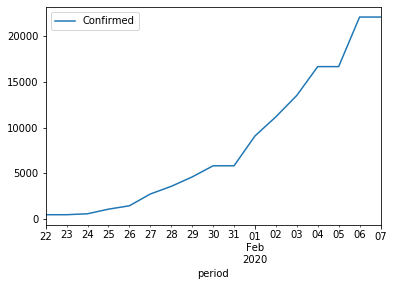

In [7]:
clean_df[clean_df['Province/State'] =='Hubei'].plot.line(x='period', y='Confirmed')
# clean_df[clean_df['Province/State'] =='Hubei']
clean_df['Last Update'].value_counts().sort_index()

In [8]:
clean_df['Province/State'].value_counts().sort_values().head(20)

Ivory Coast        1
Colombia           1
Brazil             1
Cruise Ship        1
Mexico             1
Chicago            1
Madison, WI        2
Australia          4
Belgium            4
London, ON         5
Toronto, ON        5
San Benito, CA     5
Bavaria            6
Boston, MA         7
California         7
Orange, CA         7
Santa Clara, CA    7
Spain              7
Los Angeles, CA    7
Germany            7
Name: Province/State, dtype: int64

In [9]:
clean_df['Province/State'].value_counts().sort_values().head(10).index

Index(['Ivory Coast', 'Colombia', 'Brazil', 'Cruise Ship', 'Mexico', 'Chicago',
       'Madison, WI', 'Australia', 'Belgium', 'London, ON'],
      dtype='object')

### Some Analysis on virus spread

##### Growth rate of confirmed cases

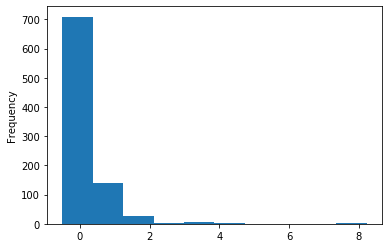

In [10]:
clean_df['Confirmed_lag'] = clean_df.groupby(['Province/State']).Confirmed.shift(1)

clean_df['growth number daily'] =  clean_df.Confirmed - clean_df.Confirmed_lag

clean_df['growth rate daily'] = clean_df.Confirmed / clean_df.Confirmed_lag - 1

clean_df[clean_df.Confirmed_lag > 0]['growth rate daily'].plot.hist()

In [11]:
clean_df[clean_df['growth rate daily']<0]

,Country/Region,Province/State,month,day,Last Update,Confirmed,Suspected,Recovered,Deaths,period,Confirmed_lag,growth number daily,growth rate daily
25,Australia,Queensland,Jan,31,2020-01-31 12:00:00,2,0,0,0,2020-01-31,3.0,-1.0,-0.333333
17,Australia,Queensland,Feb,02,2020-02-02 20:33:00,2,0,0,0,2020-02-02,3.0,-1.0,-0.333333
85,Canada,Ontario,Jan,30,2020-01-30 19:30:00,2,0,0,0,2020-01-30,3.0,-1.0,-0.333333
175,Japan,Japan,Jan,23,2020-01-23 10:00:00,1,0,0,0,2020-01-23,2.0,-1.0,-0.500000
173,Japan,Japan,Feb,07,2020-02-07 02:13:00,25,0,1,0,2020-02-07,45.0,-20.0,-0.444444


In [12]:
# focus on cases where base is above 8
heavy_affect_df = clean_df[clean_df['Confirmed_lag'] >= 8]

heavy_affect_df['day count'] = heavy_affect_df.groupby('Province/State')['period'].rank()

heavy_affect_df.describe()

/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,Confirmed,Suspected,Recovered,Deaths,Confirmed_lag,growth number daily,growth rate daily,day count
count,485.000000,485.000000,485.000000,485.000000,485.000000,485.000000,485.000000,485.000000
mean,426.705155,0.680412,15.509278,8.985567,363.777320,62.927835,0.252795,6.969072
std,2021.082686,5.373539,69.521672,59.414479,1764.522081,363.627229,0.494616,4.029472
min,8.000000,0.000000,0.000000,0.000000,8.000000,-20.000000,-0.444444,1.000000
25%,25.000000,0.000000,0.000000,0.000000,19.000000,2.000000,0.037594,4.000000
50%,70.000000,0.000000,1.000000,0.000000,59.000000,8.000000,0.137500,7.000000
75%,206.000000,0.000000,7.000000,1.000000,177.000000,25.000000,0.314815,10.000000
max,22112.000000,72.000000,867.000000,618.000000,22112.000000,5434.000000,8.222222,16.000000


In [13]:
growth_df = heavy_affect_df.pivot_table(values = 'growth rate daily', index = 'day count', columns='Province/State').reset_index()
growth_df

Province/State,day count,Anhui,Beijing,Chongqing,Fujian,Gansu,Germany,Guangdong,Guangxi,Guizhou,...,Sichuan,Singapore,South Korea,Taiwan,Thailand,Tianjin,Vietnam,Xinjiang,Yunnan,Zhejiang
0,1.0,0.666667,0.571429,2.000000,0.800000,0.357143,0.250000,0.230769,0.434783,0.000000,...,0.875000,0.000000,0.363636,0.000000,0.000000,0.625000,0.00,0.076923,0.727273,1.700000
1,2.0,3.000000,0.636364,1.777778,0.944444,0.263158,0.200000,0.656250,0.393939,0.333333,...,1.933333,0.300000,0.000000,0.125000,0.750000,0.076923,0.00,0.214286,0.368421,0.592593
2,3.0,0.166667,0.416667,0.466667,0.685714,0.083333,0.000000,0.849057,0.108696,0.250000,...,0.568182,0.384615,0.000000,0.111111,0.000000,0.642857,0.25,0.000000,0.692308,1.418605
3,4.0,0.514286,0.333333,0.200000,0.389831,0.115385,0.000000,0.489796,0.137255,0.933333,...,0.304348,0.000000,0.066667,0.000000,0.000000,0.086957,0.00,0.235294,0.250000,0.230769
4,5.0,0.433962,0.176471,0.113636,0.231707,0.000000,0.000000,0.034247,0.344828,0.310345,...,0.200000,0.000000,0.187500,0.000000,0.357143,0.080000,NaN,0.142857,0.381818,0.351562
5,6.0,0.315789,0.137500,0.122449,0.000000,0.379310,0.083333,0.596026,0.115385,0.210526,...,0.314815,0.333333,0.210526,0.000000,0.000000,0.185185,NaN,0.208333,0.092105,0.710983
6,7.0,0.185000,0.219780,0.248485,0.188119,0.275000,NaN,0.290456,0.000000,0.217391,...,0.246479,0.166667,0.043478,0.100000,0.000000,0.000000,NaN,0.103448,0.120482,0.445946
7,8.0,0.000000,0.090090,0.024272,0.325000,0.078431,NaN,0.263666,0.275862,0.142857,...,0.000000,0.000000,NaN,0.000000,0.000000,0.406250,NaN,0.000000,0.129032,0.254673
8,9.0,0.434599,0.148760,0.241706,0.000000,0.036364,NaN,0.109415,0.144144,0.000000,...,0.305085,0.071429,NaN,0.454545,0.315789,0.066667,NaN,0.125000,0.114286,0.001862
9,10.0,0.200000,0.316547,0.145038,0.125786,0.087719,NaN,0.385321,0.094488,0.109375,...,0.099567,NaN,NaN,0.000000,0.000000,0.250000,NaN,0.083333,0.042735,0.228625


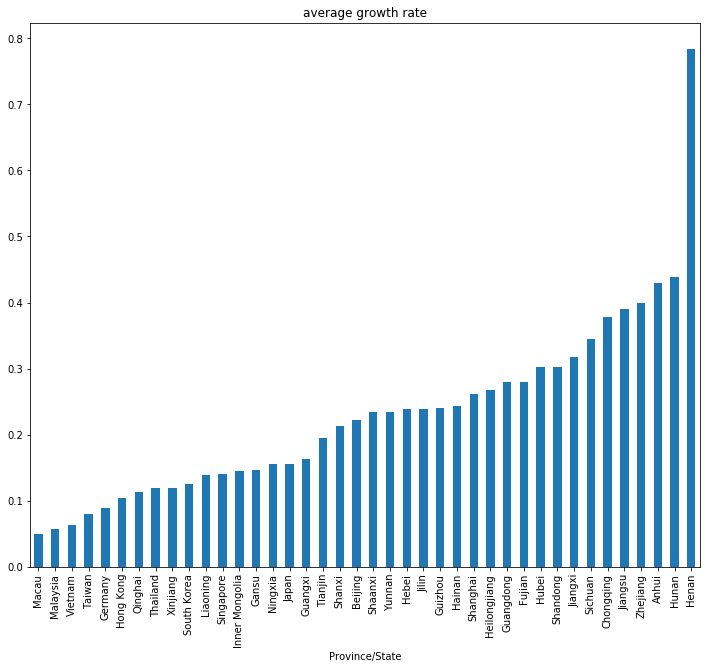

In [14]:
# arithmatic mean of growth rate
growth_df.set_index('day count').mean().sort_values().plot.bar(figsize=(12,10),
                                                              title='average growth rate')

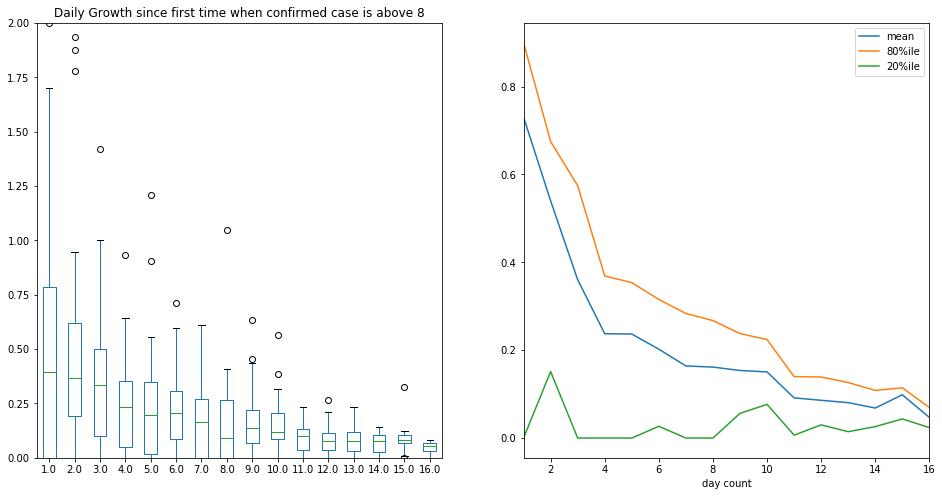

In [15]:
figure, axes = plt.subplots(nrows=1, ncols=2, figsize =(16,8))

growth_df.set_index('day count').transpose().plot.box(ax = axes[0], 
                                         title ='Daily Growth since first time when confirmed case is above 8',
                                         ylim =(0, 2))

# deceleration? caveat: ommision bias
growth_df.set_index('day count').mean(axis =1).plot(ax = axes[1])
growth_df.set_index('day count').quantile(q=0.8, axis =1).plot(ax = axes[1])
growth_df.set_index('day count').quantile(q=0.2, axis =1).plot(ax = axes[1])

axes[1].legend(['mean','80%ile','20%ile'])

In [16]:
# cumulative growth rate from base of the first time there is more than 8 "confirmed case"
earliest_df = heavy_affect_df. \
            groupby(['Province/State']). \
            agg({'Confirmed':'min'}).reset_index().rename(columns ={'Confirmed': 'base'})

earliest_df.sort_values(by='base',ascending=False).head()

,Province/State,base
14,Hubei,444
12,Henan,83
27,Shandong,39
19,Jiangxi,36
7,Guangxi,33


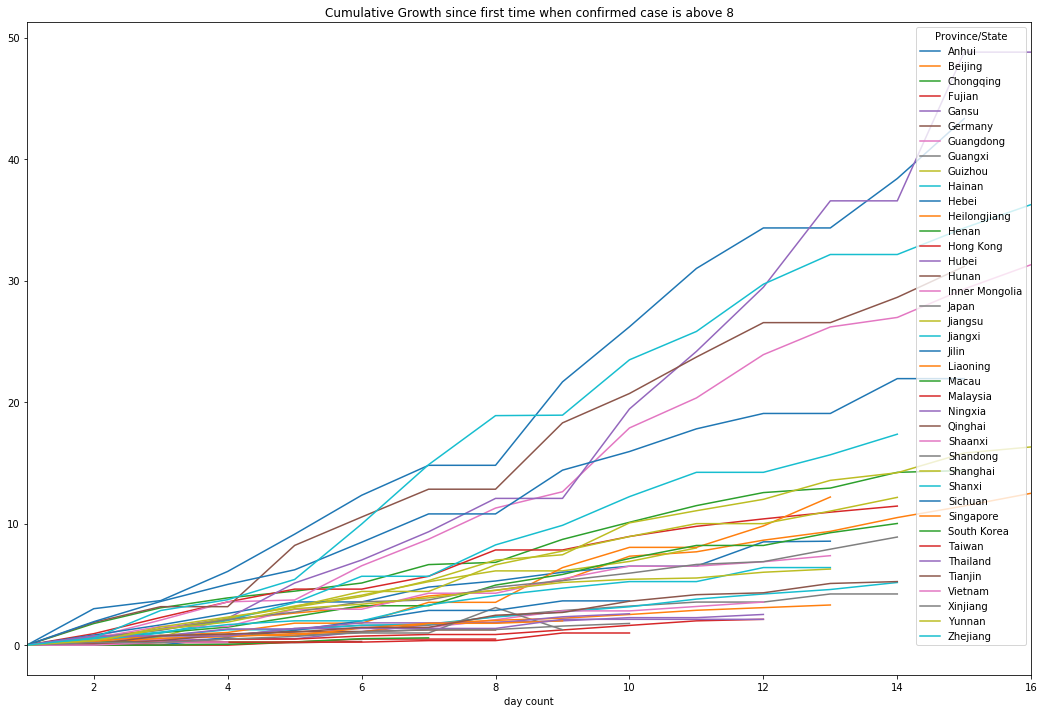

In [17]:
heavy_affect_df = pd.merge(heavy_affect_df, earliest_df, how = 'left', left_on = 'Province/State', right_on = 'Province/State')

heavy_affect_df['cumulative growth'] = heavy_affect_df['Confirmed']/ heavy_affect_df['base'] - 1
cmlt_growth_df = heavy_affect_df.pivot_table(columns ='Province/State', index= 'day count', values='cumulative growth')
cmlt_growth_df.plot.line(figsize =(18, 12), 
                                         title ='Cumulative Growth since first time when confirmed case is above 8')

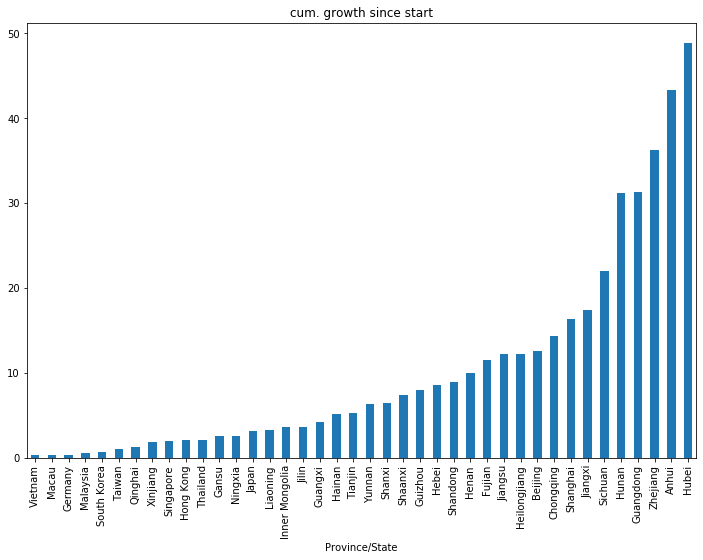

In [18]:
cmlt_growth_df.max().sort_values().plot.bar(figsize =(12,8), title='cum. growth since start')

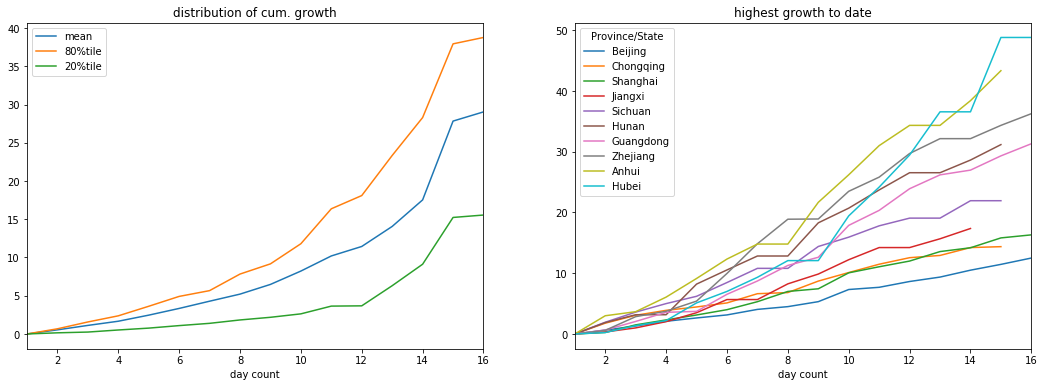

In [19]:
fig, axes = plt.subplots(nrows=1,ncols=2, figsize=(18,6))

# deceleration? (caveat: ommited variable)
cmlt_growth_df.mean(axis=1).plot(ax = axes[0])
cmlt_growth_df.quantile(q=0.8,axis=1).plot(ax = axes[0])
cmlt_growth_df.quantile(q=0.2,axis=1).plot(ax = axes[0], title ='distribution of cum. growth')

axes[0].legend(['mean','80%tile', '20%tile'])

# the following provinces/states have the top 10 cumulative growth
cmlt_growth_df[cmlt_growth_df.max().sort_values().index.tolist()[-10:]].plot.line(ax =axes[1],  
                                                                                  title = 'highest growth to date')

#### Compare China vs. Outside

In [20]:
# focus on countries outside of China
outside_df = clean_df[clean_df['Country/Region']!= 'Mainland China']

outside_agg_df = outside_df.groupby(['Country/Region','Province/State','period']). \
    agg({'Confirmed':'max','Recovered':'max','Suspected':'max','Deaths':'max'}).reset_index(). \
    groupby(['period']). \
    agg({'Confirmed':'sum','Recovered':'sum','Suspected':'sum','Deaths':'sum','Province/State':'count'}).reset_index()

## outside_agg_df['Confirmed lag'] = outside_agg_df.Confirmed.shift(1)

outside_agg_df['log_growth'] = np.log(outside_agg_df.Confirmed).diff()

In [21]:
china_df = clean_df[clean_df['Country/Region']=='Mainland China']

china_agg_df = china_df.groupby(['Country/Region','Province/State','period']). \
    agg({'Confirmed':'max','Recovered':'max','Suspected':'max','Deaths':'max'}).reset_index(). \
    groupby(['period']). \
    agg({'Confirmed':'sum','Recovered':'sum','Suspected':'sum','Deaths':'sum','Province/State':'count'}).reset_index()

china_agg_df['log_growth'] = np.log(china_agg_df.Confirmed).diff()

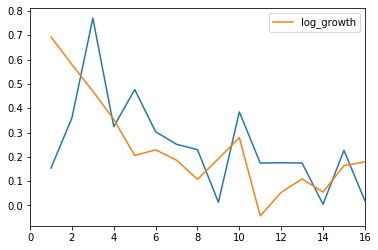

In [22]:
china_agg_df.log_growth.plot()
outside_agg_df.log_growth.plot(legend = True)

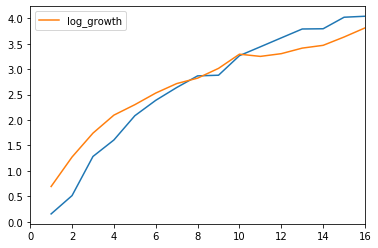

In [23]:
# cumulative growth
china_agg_df.log_growth.cumsum().plot()
outside_agg_df.log_growth.cumsum().plot(legend=True)

In [24]:
# The null hypothesis that the two distribution the same can't be reject by a simple T-test
stats.ttest_ind(china_agg_df.log_growth.dropna(), outside_agg_df.log_growth.dropna())

Ttest_indResult(statistic=0.20750193276202883, pvalue=0.8370200387942494)

#### Time-series Analysis on Growth Rate

In [25]:
# auto-correlation is quite low
print(acf(china_agg_df['log_growth'].dropna()))

# this consistent with AR test, whose lag is not significant
model = AutoReg(china_agg_df['log_growth'].dropna(), lags=1) # unable to run VAR due to missing values (synthetic control?)
results = model.fit()
results.summary()

[ 1.          0.20964965  0.29685987  0.1348532  -0.10446035  0.12113167
 -0.28204132  0.13441485 -0.05856653 -0.22173473 -0.13692395 -0.3287171
 -0.08806215 -0.17749801 -0.04031942  0.04141433]


/opt/anaconda3/envs/py37/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning
/opt/anaconda3/envs/py37/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:             log_growth   No. Observations:                   16
Model:                     AutoReg(1)   Log Likelihood                   3.926
Method:               Conditional MLE   S.D. of innovations              0.186
Date:                Sat, 08 Feb 2020   AIC                             -2.961
Time:                        21:30:55   BIC                             -2.820
Sample:                             1   HQIC                            -2.963
                                   16                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
intercept         0.1973      0.085      2.308      0.021       0.030       0.365
log_growth.L1     0.2309      0.264      0.876      0.381      -0.286       0.747
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            4.3308           +0.0000j            4.3308            0.0000
-----------------------------------------------------------------------------
"""

### Recover rate using the latest data available

In [26]:
clean_df['recover rate'] = clean_df.Recovered / clean_df.Confirmed
latest_df = clean_df.groupby(['Province/State']).agg({'Last Update': 'max'}).reset_index()

latest_df = pd.merge(clean_df, latest_df, how = 'right', left_on = ['Province/State', 'Last Update'], right_on = ['Province/State', 'Last Update'])
latest_df

,Province/State,Last Update
0,Anhui,2020-02-07 03:13:00
1,Arizona,2020-02-01 08:00:00
2,Australia,2020-01-27 07:00:00
3,Bavaria,2020-02-01 08:00:00
4,Beijing,2020-02-07 01:23:00
...,...,...
79,Vietnam,2020-02-05 23:13:00
80,Washington,2020-02-01 08:00:00
81,Xinjiang,2020-02-06 23:43:00
82,Yunnan,2020-02-07 21:23:00


Percentage over total confirmed cases: 5.63%


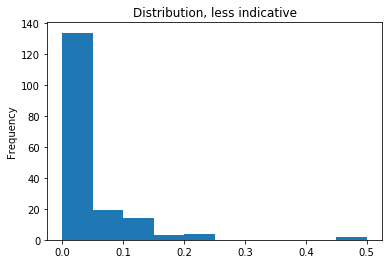

In [28]:
# Recovery rate
latest_df['recover rate'].plot.hist(title = 'Distribution, less indicative') # not much meaningful data is biased by many cases with very few confirmed case
print('Percentage over total confirmed cases: {0:.2%}'.format(latest_df.Recovered.sum() / latest_df.Confirmed.sum())) # ratio overall is more indicative

Percentage over total confirmed cases: 1.99%


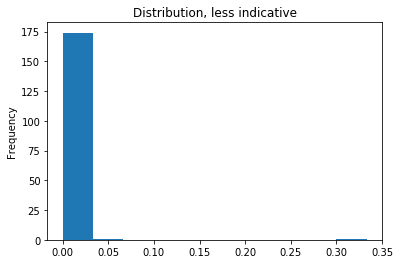

In [31]:
# Mortality rate
latest_df['mortality rate'] = latest_df.Deaths / latest_df.Confirmed
latest_df['mortality rate'].plot.hist(title = 'Distribution, less indicative') # not much meaningful data is biased by many cases with very few confirmed case
print('Percentage over total confirmed cases: {0:.2%}'.format(latest_df.Deaths.sum() / latest_df.Confirmed.sum())) # ratio overall is more indicative

### ***Retired-*** 

In [29]:
# #### Alternative method choose worksheet before merging (read from Excel manually downloaded)

# file_path = 'Novel Coronavirus (2019-nCoV) Cases, provided by JHU CSSE.xlsx'
# # raw_df = pd.concat(pd.read_excel(file_path, sheet_name= None), ignore_index = True, sort=True)

# xl = pd.ExcelFile(file_path)
# xl.sheet_names

# # use the latest time for each date
# split_name_df = pd.DataFrame(data = list(map(lambda x: x.split('_'), xl.sheet_names)), columns =['date','hour'])
# split_name_df

# # extract time components
# split_name_df['suffix'] = split_name_df.hour.apply(lambda x: x[-2:])

# split_name_df['hour_digit'] = split_name_df.hour.str.extract(r'(?P<hour>[\d]+)')

# split_name_df['date_digit'] = split_name_df.date.str.extract('([\d]+)').astype(int)

# # deal with special case of 12am and half-hour

# split_name_df.loc[split_name_df.hour == '12am', 'date_digit'] = split_name_df.loc[split_name_df.hour == '12am', 'date_digit'] - 1

# split_name_df['hour_digit'] = split_name_df.hour_digit.str.replace('30','').astype(int)

# split_name_df.loc[split_name_df.hour == '12am', 'hour_digit'] = 24

# split_name_df.loc[split_name_df.hour == '12am', 'suffix'] = 'pm'

# # filter for the last file for each day

# filter_name_df = split_name_df[split_name_df.suffix == 'pm']

# filter_name_df = filter_name_df.groupby('date_digit').agg({'hour_digit':'max','suffix': 'max'}).reset_index()

# filter_name_df

# filter_name_df = pd.merge(split_name_df,filter_name_df, how = 'right', 
#          left_on = ['date_digit', 'hour_digit','suffix'], right_on = ['date_digit','hour_digit','suffix'])

# filter_name = (filter_name_df.date + '_' + filter_name_df.hour).to_list()
# filter_name

# main_2_df = pd.concat(pd.read_excel(file_path, sheet_name= filter_name), ignore_index = True)
# main_2_df['Last Update'].value_counts()

In [30]:
# def read_excel_sheets(xls_path):
#     """Read all sheets of an Excel workbook and return a single DataFrame"""
#     print(f'Loading {xls_path} into pandas')
#     xl = pd.ExcelFile(xls_path)
#     df = pd.DataFrame()
#     columns = None
#     for idx, name in enumerate(xl.sheet_names):
#         print(f'Reading sheet #{idx}: {name}')
#         sheet = xl.parse(name)
#         if idx == 0:
#             # Save column names from the first sheet to match for append
#             columns = sheet.columns
#         sheet.columns = columns
#         # Assume index of existing data frame when appended
#         df = df.append(sheet, ignore_index=True)
#     return df

# read_excel_sheets(file_name)